<a href="https://colab.research.google.com/github/Minatozaki0911/CV202/blob/main/CV202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras

In [77]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
import seaborn as sn
import pandas as pd

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/leapGestRecog/'
model_path = '/content/drive/MyDrive/Colab Notebooks/CV202_Model'

In [ ]:
### Encode image label from image name
labels = dict()
count = 0
subdir = sorted(os.listdir(os.path.join(dataset_path, str("01/"))))
for i in subdir:
  labels[i] = count
  count += 1
print(labels)

In [ ]:
x_data = []
y_data = []
datacount = 0 
for i in range(1,3):
  print(i)
  for subdir in os.listdir(os.path.join(dataset_path, str("0"+str(i)+"/"))):
    count = 0
    print(subdir)
    for k in os.listdir(dataset_path + "0" + str(i) + "/" + subdir + "/" ):
      print(k)
      image = cv2.imread(dataset_path + "0" + str(i) + "/" + subdir + "/" + k, cv2.IMREAD_GRAYSCALE) # L = Luminance + grayscale
      image = cv2.resize(image, (320,120))
      arr = np.array(image)

      x_data.append(arr)
      count += 1    # Number of image in dataset
    y_label = np.full(shape=(count, 1), fill_value=labels[subdir])
    y_data.append(y_label)
    datacount += count

x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1)
print(datacount)
print(x_data.shape, y_data.shape)


In [ ]:
x_data = np.expand_dims(x_data, axis=-1)    # expand dimension to fit 4D tensor format
x_data /= 255
print(x_data.shape)
y_data = to_categorical(y_data)  # one hot encoding
print(y_data.shape)

(4000, 120, 320, 1)
(4000, 10)


In [ ]:
### Making Train - Validate - Test dataset with ratio 8-1-1
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5)
print(x_train.shape, x_valid.shape, x_test.shape)

(3200, 120, 320, 1) (400, 120, 320, 1) (400, 120, 320, 1)


In [28]:
def modelInit():
  input = Input(shape =(x_train.shape[1:]))

  # 1st Conv Block
  x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
  x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
  x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

  # 2nd Conv Block
  x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
  x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
  x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

  # Fully connected layers
  x = Flatten()(x)
  x = Dense(units = 1024, activation ='relu')(x)
  x = Dense(units = 512, activation ='relu')(x)
  output = Dense(units = 10, activation ='softmax')(x)
  return Model(inputs=input, outputs=output)

In [82]:
model1 = modelInit()
model1.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 320, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 320, 64)      640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 320, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 160, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 160, 128)      73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 160, 128)      147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 80, 128)       0   

In [32]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.9, staircase=True)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [33]:
history = model1.fit(x_train, y_train, 
                    epochs=7, 
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/7
50/50 [==============================] - 20s 393ms/step - loss: 0.4629 - acc: 0.8728 - val_loss: 0.0286 - val_acc: 0.9850
Epoch 2/7
50/50 [==============================] - 19s 389ms/step - loss: 0.0447 - acc: 0.9891 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3/7
50/50 [==============================] - 20s 391ms/step - loss: 7.8412e-04 - acc: 1.0000 - val_loss: 9.7773e-05 - val_acc: 1.0000
Epoch 4/7
50/50 [==============================] - 20s 395ms/step - loss: 1.2408e-04 - acc: 1.0000 - val_loss: 5.0780e-05 - val_acc: 1.0000
Epoch 5/7
50/50 [==============================] - 20s 399ms/step - loss: 5.8898e-05 - acc: 1.0000 - val_loss: 3.1743e-05 - val_acc: 1.0000
Epoch 6/7
50/50 [==============================] - 20s 400ms/step - loss: 4.1077e-05 - acc: 1.0000 - val_loss: 2.2223e-05 - val_acc: 1.0000
Epoch 7/7
50/50 [==============================] - 20s 400ms/step - loss: 2.9703e-05 - acc: 1.0000 - val_loss: 1.7015e-05 - val_acc: 1.0000


In [85]:
model.save("CV202Model")

INFO:tensorflow:Assets written to: CV202Model/assets


In [38]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


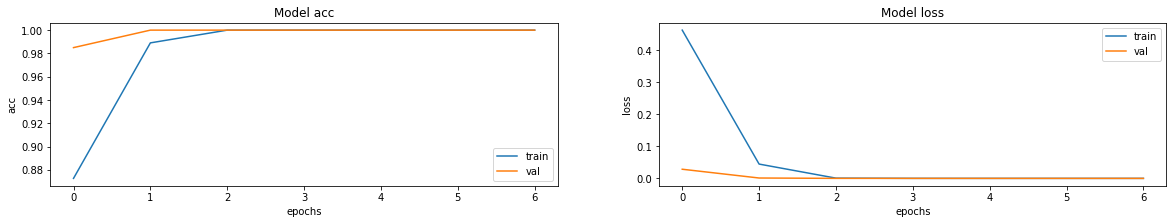

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model1.history.history[metric])
    ax[i].plot(model1.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [79]:
model1.evaluate(x_test, y_test)

13/13 [==============================] - 1s 59ms/step - loss: 2.6671e-05 - acc: 1.0000


[2.667122498678509e-05, 1.0]

In [70]:
y_pred = model1.predict(x_test) 
print(y_pred.shape)
labels = list(labels)
print(labels)

(400, 10)
['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


Test data number 300
10_down


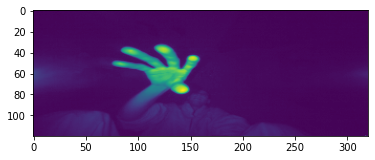

In [66]:
result = labels[np.argmax(y_pred[i])]
print("Test data number "+str(i))
print(result)
plt.imshow(np.squeeze(x_test[i], axis=2))
plt.show()

Confusion matrix


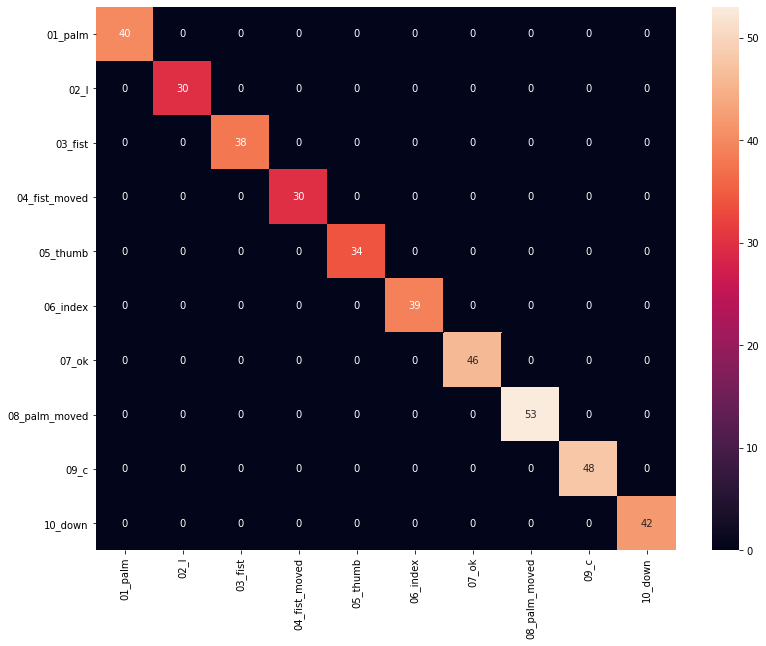

In [84]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Confusion matrix")
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (13,10))
sn.heatmap(df_cm, annot=True)

In [81]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=labels))

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00        40
         02_l       1.00      1.00      1.00        30
      03_fist       1.00      1.00      1.00        38
04_fist_moved       1.00      1.00      1.00        30
     05_thumb       1.00      1.00      1.00        34
     06_index       1.00      1.00      1.00        39
        07_ok       1.00      1.00      1.00        46
08_palm_moved       1.00      1.00      1.00        53
         09_c       1.00      1.00      1.00        48
      10_down       1.00      1.00      1.00        42

     accuracy                           1.00       400
    macro avg       1.00      1.00      1.00       400
 weighted avg       1.00      1.00      1.00       400

